# Inequality Analysis

Basketball Data Science (BDS) uses the concept of inequality from economics and applies it to basketball. Just as wealth ranges from perfect equality to maximum inequality, the distribution of counting statistics for a team can be treated similarly. Many are increasingly noting the [star-centered or heliocentric nature](https://twitter.com/SethPartnow/status/1263123339217981440?s=20) of successful NBA teams, and such a pattern should be present in an inequality analysis. As stars dominate the production on their teams, inequality should be greater on those teams compared to a more balanced one. Ben Taylor's book [Thinking Basketball](https://www.amazon.com/Thinking-Basketball-Ben-Taylor/dp/1532968175/ref=nodl_) provides great insight on this topic, along with many others.

The following goes through Section 2.2.7 of Chapter 2 in [Basketball Data Science with Applications in R](https://www.amazon.com/Basketball-Data-Science-Applications-Chapman-dp-1138600792/dp/1138600792/ref=mt_paperback?_encoding=UTF8&me=&qid=), reproducing the analysis by leveraging data from the [stats.nba.com](https://stats.nba.com) API.

In [1]:
import numpy as np
import pandas as pd
from plotnine import *
import time

from py_ball import league_dash

HEADERS = {'Connection': 'keep-alive',
           'Host': 'stats.nba.com',
           'Origin': 'http://stats.nba.com',
           'Upgrade-Insecure-Requests': '1',
           'Referer': 'stats.nba.com',
           'x-nba-stats-origin': 'stats',
           'x-nba-stats-token': 'true',
           'Accept-Language': 'en-US,en;q=0.9',
           "X-NewRelic-ID": "VQECWF5UChAHUlNTBwgBVw==",
           'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6)' +\
                         ' AppleWebKit/537.36 (KHTML, like Gecko)' + \
                         ' Chrome/81.0.4044.129 Safari/537.36'}

pd.options.mode.chained_assignment = None  # Disabling pandas SetWithCopyWarnings

## Inequality

Basketball is filled with counting statistics: points, assists, rebounds, and so on. The concept of inequality that BDS considers here is that these counting statistics may be distributed differently across players on teams. If a few players account for the majority of a particular counting statistic, the team's inequality in this dimension would be high. Conversely, if a team balances a counting statistic across all players, a team's inequality in this dimension would be low.

### Lorenz Curve
To get to a formula for inequality, two terms need to be defined and these establish the [Lorenz curve](https://en.wikipedia.org/wiki/Lorenz_curve). As stated in that Wikipedia article, "the Lorenz curve is a probability plot comparing the distribution of a parameter in a population against a hypothetical uniform distribution of that parameter."

Consider a team of $n$ players and order them in increasing order of a given counting statistic, say points. For each player $i$ from 1 to $n$, $F$ is the cumulative fraction of the population (players):

$F_i = i / n$

Then, the Lorenz curve, $L(F)$, at the point for player $i$ is

$L_i = \frac{S_i}{S_n}$

where $S_i$ is the cumulative value of the counting statistic up to and including player $i$ and $S_n$ is the sum of the counting statistics across all players. This may be a good time for an example! The following table gives the number of points scored by 8 members of the 2017-18 Oklahoma City Thunder (Table 2.6 in BDS)

**Player** | **$F_i$** | **PTS** | **$S_i$** | **$L_i$**
--- | --- | --- | --- | ----
Patrick Patterson | 0.125 | 318 | 318 | 4.0%
Alex Abrines | 0.25 | 353 | 671 | 8.4%
Raymond Felton | 0.375 | 565 | 1236 | 15.5%
Jerami Grant | 0.5 | 682 | 1918 | 24.0%
Steven Adams | 0.625 | 1056 | 2974 | 37.2%
Carmelo Anthony | 0.75 | 1261 | 4235 | 53.0%
Paul George | 0.875 | 1734 | 5969 | 74.6%
Russell Westbrook | 1 | 2028 | 7997 | 100.0%

Note how $S_i$ isn't simply points for that player, but the cumulative points up to and including that player, starting with the player having the lowest number of points. Then, $L_i$ is each $S_i$ divided by $S_n$, which is 7997 points in this case, the total across all players.

### Gini Coefficient

The [Gini coefficient](https://en.wikipedia.org/wiki/Gini_coefficient) leverages the Lorenz curve and, as BDS notes, is "the ratio of the inequality area to the total area between the line of equality and the line of maximal inequality". That's a lot of words, but the Gini coefficient ranges from 0 (maximal equality) to 1 (maximal inequality). We'll see what that area looks like in a bit, but the Wikipedia article describes it nicely as well.

The Gini coefficient $G$ is calculated as

$G = \frac{\Sigma_{1}^{n - 1}(F_i - L_i)}{\Sigma_{1}^{n - 1} F_i}$,

which can be interpreted as the summed difference between the actual cumulative fraction of the statistic of interest and what's expected under maximal equality. Okay, enough with the background. Onto the data.

### Data

The [stats.nba.com](https://stats.nba.com) API contains the `leaguedashplayerstats` endpoint that has tons of player performance data by many different splits. You can explore the information available in the documentation [here](https://github.com/basketballrelativity/py_ball/wiki/LeagueDash).

The following leverages the `LeagueDash` class from the `py_ball` package to use data from the `leaguedashplayerstats` endpoint to replicate the inequality visualizations in BDS.

In [2]:
TEAM_TO_ID_NBA = {'TOR': '1610612761', 'DEN': '1610612743',
                  'DET': '1610612765', 'NOP': '1610612740',
                  'MIL': '1610612749', 'GSW': '1610612744',
                  'SAS': '1610612759', 'POR': '1610612757',
                  'LAC': '1610612746', 'DAL': '1610612742',
                  'MEM': '1610612763', 'PHI': '1610612755',
                  'BOS': '1610612738', 'MIN': '1610612750',
                  'CHA': '1610612766', 'IND': '1610612754',
                  'ORL': '1610612753', 'MIA': '1610612748',
                  'HOU': '1610612745', 'SAC': '1610612758',
                  'UTA': '1610612762', 'BKN': '1610612751',
                  'ATL': '1610612737', 'PHX': '1610612756',
                  'WAS': '1610612764', 'NYK': '1610612752',
                  'OKC': '1610612760', 'LAL': '1610612747',
                  'CLE': '1610612739', 'CHI': '1610612741'}

The `league_dash` endpoints require some parameters:
- `league_id`: '00' for NBA, '10' for WNBA, '20' for G-League
- `per_mode`: One of 'Totals', 'PerGame', 'MinutesPer', 'Per48', 'Per40', 'Per36', 'PerMinute', 'PerPossession', 'PerPlay', 'Per100Possessions', 'Per100Plays' which dictates whether totals or specific rate statistics are returned
- `season`: For the NBA, season in YYYY-ZZ format. For the WNBA, YYYY format. YYYY is the year in which the season begins, ZZ are the trailing two digits of the following year.
- `measure_type`: One of 'Base', 'Advanced', 'Misc', 'Scoring', 'Opponent', 'Usage' which dictates the type of statistics returned
- `team_id`: String of a 10-digit unique team identifier. '0' returns data across all teams

In [3]:
league_id = '00'
per_mode = 'Totals'
season = '2017-18'
measure_type = 'Base'
team_id = '0'

player_data = league_dash.LeagueDash(headers=HEADERS,
                                     endpoint='leaguedashplayerstats',
                                     league_id=league_id,
                                     season=season,
                                     measure_type=measure_type,
                                     per_mode=per_mode,
                                     team_id=team_id)
player_df = pd.DataFrame(player_data.data['LeagueDashPlayerStats'])

Let's check out the DataFrame and what features are available.

In [4]:
player_df

,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,AGE,GP,W,L,W_PCT,MIN,...,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,NBA_FANTASY_PTS_RANK,DD2_RANK,TD3_RANK,CFID,CFPARAMS
0,201166,Aaron Brooks,1610612750,MIN,33.0,32,19,13,0.594,189.413333,...,129,145,423,410,409,425,228,32,5,"201166,1610612750"
1,203932,Aaron Gordon,1610612753,ORL,22.0,58,19,39,0.328,1909.078333,...,438,319,67,66,439,72,30,32,5,"203932,1610612753"
2,1626151,Aaron Harrison,1610612742,DAL,23.0,9,2,7,0.222,233.251667,...,1,142,413,423,405,424,228,32,5,"1626151,1610612742"
3,1628935,Aaron Jackson,1610612745,HOU,32.0,1,0,1,0.000,34.500000,...,57,47,471,498,281,504,228,32,5,"1628935,1610612745"
4,1627846,Abdel Nader,1610612738,BOS,24.0,48,33,15,0.688,521.526667,...,215,182,355,370,454,376,228,32,5,"1627846,1610612738"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,1628380,Zach Collins,1610612757,POR,20.0,66,41,25,0.621,1045.450000,...,273,377,296,298,181,284,228,32,5,"1628380,1610612757"
536,203897,Zach LaVine,1610612741,CHI,23.0,24,9,15,0.375,656.286667,...,386,205,254,260,485,300,228,32,5,"203897,1610612741"
537,2216,Zach Randolph,1610612758,SAC,36.0,59,18,41,0.305,1507.611667,...,430,335,131,114,529,142,64,32,5,"2216,1610612758"
538,2585,Zaza Pachulia,1610612744,GSW,34.0,69,47,22,0.681,971.746667,...,410,346,200,268,60,234,151,32,5,"2585,1610612744"


In [5]:
list(player_df)

['PLAYER_ID',
 'PLAYER_NAME',
 'TEAM_ID',
 'TEAM_ABBREVIATION',
 'AGE',
 'GP',
 'W',
 'L',
 'W_PCT',
 'MIN',
 'FGM',
 'FGA',
 'FG_PCT',
 'FG3M',
 'FG3A',
 'FG3_PCT',
 'FTM',
 'FTA',
 'FT_PCT',
 'OREB',
 'DREB',
 'REB',
 'AST',
 'TOV',
 'STL',
 'BLK',
 'BLKA',
 'PF',
 'PFD',
 'PTS',
 'PLUS_MINUS',
 'NBA_FANTASY_PTS',
 'DD2',
 'TD3',
 'GP_RANK',
 'W_RANK',
 'L_RANK',
 'W_PCT_RANK',
 'MIN_RANK',
 'FGM_RANK',
 'FGA_RANK',
 'FG_PCT_RANK',
 'FG3M_RANK',
 'FG3A_RANK',
 'FG3_PCT_RANK',
 'FTM_RANK',
 'FTA_RANK',
 'FT_PCT_RANK',
 'OREB_RANK',
 'DREB_RANK',
 'REB_RANK',
 'AST_RANK',
 'TOV_RANK',
 'STL_RANK',
 'BLK_RANK',
 'BLKA_RANK',
 'PF_RANK',
 'PFD_RANK',
 'PTS_RANK',
 'PLUS_MINUS_RANK',
 'NBA_FANTASY_PTS_RANK',
 'DD2_RANK',
 'TD3_RANK',
 'CFID',
 'CFPARAMS']

Looks like there are plenty of counting statistics available to explore, so let's run through an example of `PTS` for the 2017-18 Philadelphia 76ers. As BDS notes, we should settle on a constant number of players. This will make comparing across teams easier, so we'll choose 8 as done in BDS Table 2.6 (repeated above). We'll take the top 8 scoring players here:

In [6]:
team_df = player_df[player_df['TEAM_ID'] ==
                    int(TEAM_TO_ID_NBA['PHI'])].sort_values("PTS").tail(8)

In [7]:
team_df

,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,AGE,GP,W,L,W_PCT,MIN,...,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,NBA_FANTASY_PTS_RANK,DD2_RANK,TD3_RANK,CFID,CFPARAMS
468,204456,T.J. McConnell,1610612755,PHI,26.0,76,50,26,0.658,1706.613333,...,386,346,296,227,403,168,151,15,5,"204456,1610612755"
158,101141,Ersan Ilyasova,1610612755,PHI,31.0,69,36,33,0.522,1729.648333,...,342,436,100,144,161,144,71,32,5,"101141,1610612755"
348,201158,Marco Belinelli,1610612755,PHI,32.0,80,39,41,0.488,1946.731667,...,314,268,115,84,328,149,228,32,5,"201158,1610612755"
435,203496,Robert Covington,1610612755,PHI,27.0,80,51,29,0.638,2531.365000,...,438,534,150,72,2,46,71,32,5,"203496,1610612755"
98,203967,Dario Saric,1610612755,PHI,24.0,78,49,29,0.628,2310.070000,...,493,444,90,50,36,60,44,32,5,"203967,1610612755"
197,200755,JJ Redick,1610612755,PHI,34.0,70,45,25,0.643,2115.853333,...,386,352,97,46,29,115,228,32,5,"200755,1610612755"
40,1627732,Ben Simmons,1610612755,PHI,21.0,81,51,30,0.630,2731.553333,...,473,517,22,36,11,8,11,3,5,"1627732,1610612755"
252,203954,Joel Embiid,1610612755,PHI,24.0,63,41,22,0.651,1912.135000,...,525,515,7,25,6,21,11,32,5,"203954,1610612755"


$F_i$ is easy to calculate, as the DataFrame is already sorted in order of increasing points.

In [8]:
team_df['F_i'] = np.linspace(1/8, 1, 8)

The following for-loop simply loops through points and adds them to the `cum_values` variable, which is $S_i$ in the formula above. Then, $L_i$ is taken by dividing $S_i$ by the total points across all players ($S_n$).

In [9]:
cum_list = []
cum_values = 0
for vals in team_df['PTS']:
    cum_values += vals
    cum_list.append(cum_values / sum(team_df['PTS']))
team_df['L_i'] = cum_list

Now, we have all we need to visualize the Lorenz curve! Let's establish a separate DataFrame for visualization.

In [10]:
cum_df = pd.DataFrame({'F_i': [0] + list(team_df['F_i']),
                       'L_i': [0] + list(team_df['L_i'])})

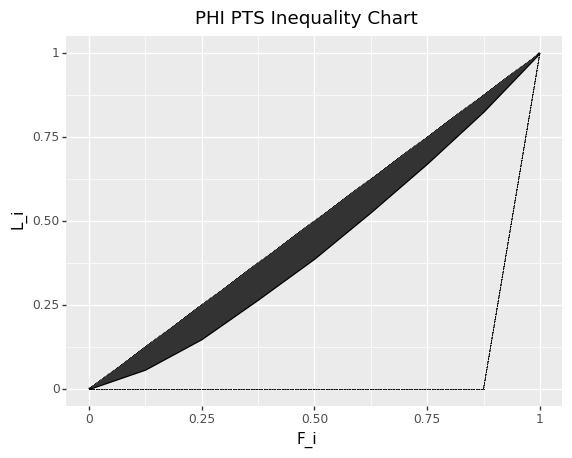

<ggplot: (302771585)>

In [11]:
ggplot(data=cum_df) \
    + geom_line(mapping=aes(x='F_i', y='L_i'),
                colour="black", size=1) \
    + geom_segment(mapping=aes(x = 0, xend = 1, y = 0, yend = 1),
                   colour="black", size=0.25, linetype='dotted') \
    + geom_segment(mapping=aes(x = 0, xend = 7/8, y = 0, yend = 0),
                   colour="black", size=0.25, linetype='dotted') \
    + geom_segment(mapping=aes(x = 7/8, xend = 1, y = 0, yend = 1),
                   colour="black", size=0.25, linetype='dotted') \
    + geom_ribbon(mapping=aes(x='F_i', ymin='L_i',ymax='F_i')) \
    + ggtitle('PHI PTS Inequality Chart')

There are several noteworthy aspects of this chart:

- The dashed line along the horizontal axis that shoots up to the point $L_i = 1$ and $F_i = 1$ is the line of maximal inequality. In this example, this would be a team where one player scores all of the points!
- The line $F_i = L_i$, which is the top of the filled area, is the line of maximal equality. In this example, this would be a team where all players score the same number of points.
- The filled area corresponds to the Gini coefficient! This is the area between the lines of maximal inequality and equality.

Now that we've walked through how to calculate the values needed for the Lorenz curve, we can abstract it away in the following `inequality_chart` function.

In [12]:
def inequality_chart(team, player_df, stat):
    """ This function creates a Lorenz curve for
    the provided team and counting statistic. Note,
    this is hardcoded to use the top 8 players by
    the statistic stat

    @param team (str): Three-letter team identifier
        in the TEAM_TO_ID_NBA dictionary at the top
        of this notebook
    @param player_df (DataFrame): DataFrame containing
        a season's worth of counting statistics for players
    @param stat (str): String corresponding to a
        counting statistic in player_df

    Returns

        - p (plotnine.ggplot.ggplot): plotnine visualization
            object containing the Lorenz chart
    """

    # Subset the team and calculate F_i
    team_df = player_df[player_df['TEAM_ID'] ==
                        int(TEAM_TO_ID_NBA[team])].sort_values(stat).tail(8)
    team_df['F_i'] = np.linspace(1/8, 1, 8)

    # Calculate S_i and L_i
    cum_list = []
    cum_values = 0
    for vals in team_df[stat]:
        cum_values += vals
        cum_list.append(cum_values / sum(team_df[stat]))
    team_df['L_i'] = cum_list

    # Create visualization
    cum_df = pd.DataFrame({'Cumulative Player Percentage': [0] + list(team_df['F_i']),
                           'Cumulative Value Percentage': [0] + list(team_df['L_i'])})

    p = ggplot(data=cum_df) \
        + geom_line(mapping=aes(x='Cumulative Player Percentage',
                                y='Cumulative Value Percentage'),
                    colour="black", size=1) \
        + geom_segment(mapping=aes(x = 0, xend = 1, y = 0, yend = 1),
                       colour="black", size=0.25, linetype='dotted') \
        + geom_segment(mapping=aes(x = 0, xend = 7/8, y = 0, yend = 0),
                       colour="black", size=0.25, linetype='dotted') \
        + geom_segment(mapping=aes(x = 7/8, xend = 1, y = 0, yend = 1),
                       colour="black", size=0.25, linetype='dotted') \
        + geom_ribbon(mapping=aes(x='Cumulative Player Percentage',
                                  ymin='Cumulative Value Percentage',
                                  ymax='Cumulative Player Percentage')) \
        + ggtitle(team + ' ' + stat + ' Inequality Chart')

    return p

Figure 2.11 in BDS plots the most extreme example of inequality and equality by points, so let's repeat that here.

In [13]:
bkn_pts_inequality = inequality_chart('BKN', player_df, 'PTS')
mil_pts_inequality = inequality_chart('MIL', player_df, 'PTS')

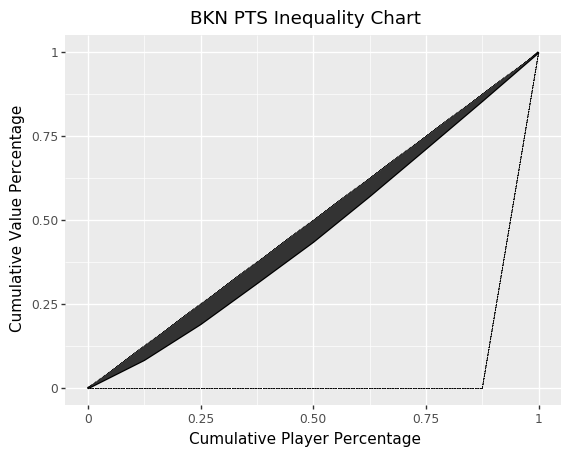

<ggplot: (307391669)>

In [14]:
bkn_pts_inequality

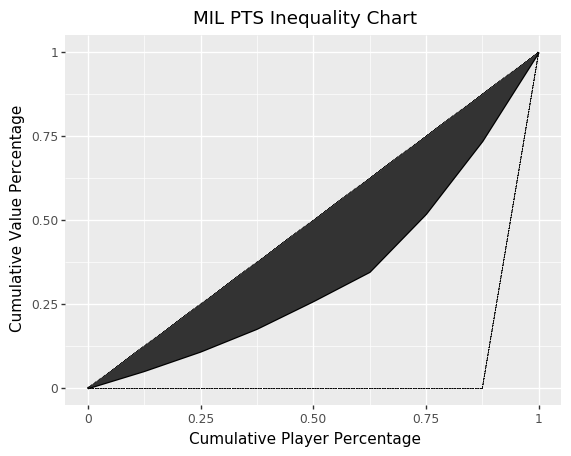

<ggplot: (307391601)>

In [15]:
mil_pts_inequality

- The Bucks high inequality is likely due to their star, Giannis Antetokounmpo, carrying the load from a scoring perspective
- The Nets had a remarkable 8 players average between 10 and 13.5 points per game, which explains their balanced scoring attack

The final piece is to calculate the Gini coefficient for all teams and visualize the league as a whole, as done in BDS Figure 2.12.

In [16]:
def league_inequality_chart(player_df, stat):
    """ This function creates a Gini coefficient
    visualization for the provided counting statistic. Note,
    this is hardcoded to use the top 8 players by
    the statistic stat

    @param player_df (DataFrame): DataFrame containing
        a season's worth of counting statistics for players
    @param stat (str): String corresponding to a
        counting statistic in player_df

    Returns

        - p (plotnine.ggplot.ggplot): plotnine visualization
            object containing the Gini coefficient viz
    """

    # Subset the team and calculate F_i
    gini_list = []
    gini_team = []
    gini_val = []
    for team in TEAM_TO_ID_NBA:
        team_df = player_df[player_df['TEAM_ID'] ==
                        int(TEAM_TO_ID_NBA[team])].sort_values(stat).tail(8)
        team_df['F_i'] = np.linspace(1/8, 1, 8)

        # Calculate S_i and L_i
        cum_list = []
        cum_values = 0
        for vals in team_df[stat]:
            cum_values += vals
            cum_list.append(cum_values / sum(team_df[stat]))
        team_df['L_i'] = cum_list

        cum_df = pd.DataFrame({'Cumulative Player Percentage': [0] + list(team_df['F_i']),
                               'Cumulative Value Percentage': [0] + list(team_df['L_i'])})

        # Calculate the Gini coefficient
        gini = sum(cum_df['Cumulative Player Percentage'] - 
                   cum_df['Cumulative Value Percentage']) \
            / sum(cum_df['Cumulative Player Percentage'])

        # Store the values
        gini_list.append(gini)
        gini_team.append(team)
        gini_val.append(sum(team_df[stat]) / 82)

    # Create Visualization
    gini_df = pd.DataFrame({'Gini Coefficient': gini_list,
                            'Team': gini_team,
                            stat + ' per Game': gini_val})

    p = ggplot(data=gini_df) \
        + geom_point(mapping=aes(x='Gini Coefficient',
                                 y=stat + ' per Game'), alpha=0.1) \
        + geom_text(mapping=aes(x='Gini Coefficient',
                                y=stat + ' per Game',
                                label='Team'),
                    position=position_jitter(width=0,height=0.5), size=10) \
        + ggtitle(stat + ' Inequality Chart')
    p

    return p

In [21]:
pts_chart = league_inequality_chart(player_df, 'PTS')

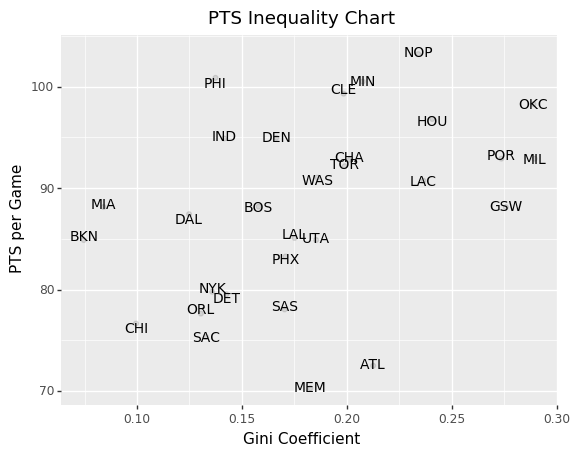

<ggplot: (307785041)>

In [22]:
pts_chart

- Note the teams with stars clustered to the higher end of the Gini coefficient

## Conclusion

This notebook introduces the concept of inequality and applies it to basketball counting statistics. These key concepts are related to the star-centered nature of the NBA, as discussed in [Thinking Basketball](https://www.amazon.com/Thinking-Basketball-Ben-Taylor/dp/1532968175/ref=nodl_) and BDS uses the distribution of points to demonstrate inequality.

This can be extended to other counting statistics! Try repeating the above for rebounds or asssists, examining how those statistics are distributed across players on a team.